In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import linregress
from scipy.stats import pearsonr
from scipy.stats import f_oneway, kruskal
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

## Load in Data

In [2]:
raw_data = pd.read_excel('steriod_study_data.xlsx')

## Clean Data

In [3]:
data = raw_data.iloc[0:22,:14]

In [4]:
data

,ID,group,gdf15_before,gdf15_after,help_before,help_after,puqe_before,puqe_after,gdf15_change,help_change,puqe_change,help_reduction,puqe_reduction,gdf15_percent_change
0,K37,Steroid,8.625892,6.608038,38,10,10,3,-2.017855,-28,-7.0,28,7,-23.392997
1,L14,Steroid,22.974399,24.424706,30,29,11,9,1.450307,-1,-2.0,1,2,6.312710
2,L23,Steroid,23.262108,21.79778,40,21,15,10,-1.464328,-19,-5.0,19,5,-6.294906
3,L37,Steroid,6.889565,12.498578,30,17,12,9,5.609013,-13,-3.0,13,3,81.413157
4,M35,Steroid,14.082705,10.614804,37,31,14,12,-3.467901,-6,-2.0,6,2,-24.625249
5,N2,Steroid,8.569502,6.617576,55,21,15,7,-1.951926,-34,-8.0,34,8,-22.777590
6,P5,Steroid,20.255376,16.678638,42,14,8,4,-3.576739,-28,-4.0,28,4,-17.658219
7,H10,Steroid,19.398124,16.526182,43,11,14,4,-2.871942,-32,-10.0,32,10,-14.805256
8,H1,Steroid,12.664902,10.569372,28,9,11,4,-2.09553,-19,-7.0,19,7,-16.545963
9,H3,Steroid,11.817524,10.433036,34,12,12,6,-1.384488,-22,-6.0,22,6,-11.715551


In [5]:
# Update column data types
data_update = data.astype({'gdf15_before':float, 'gdf15_after':float, 'help_before':float, 'help_after':float, 'puqe_before':float,
                    'puqe_after':float, 'gdf15_change':float, 'help_change':float, 'puqe_change':float, 'help_reduction':float, 
                     'puqe_reduction':float, 'gdf15_percent_change':float})


In [6]:
data_update.dtypes

ID                       object
group                    object
gdf15_before            float64
gdf15_after             float64
help_before             float64
help_after              float64
puqe_before             float64
puqe_after              float64
gdf15_change            float64
help_change             float64
puqe_change             float64
help_reduction          float64
puqe_reduction          float64
gdf15_percent_change    float64
dtype: object

## Boxplots and Statistical Significance Tests

In [7]:
# Function for boxplots to analyze various attribute distribution amongst those with and without Steriod
def dist_boxplot(df, col):
    sns.boxplot(data=df, x='group', y=col, hue='group', legend=False)
    plt.title(col + " by treatment")

# Function to test for Statistical Significance in Difference between Sample Means
def perform_statistical_tests(data, group_column, value_column, group1, group2):
    """
    Perform statistical tests (normality tests and t-tests or Mann-Whitney U tests) between two groups.

    Parameters:
    - data: DataFrame containing the data.
    - group_column: Column name indicating the group (e.g., 'Race').
    - value_column: The column containing the values to test (e.g., 'IGFBP7').
    - group1: The first group to compare (e.g., 'black').
    - group2: The second group to compare (e.g., 'white').
    """
    # Filter and remove NaN values for both groups
    group1_data = data[data[group_column] == group1][value_column].dropna()
    group2_data = data[data[group_column] == group2][value_column].dropna()

    # Check the sample size
    if len(group1_data) < 3 or len(group2_data) < 3:
        print(f"Not enough data for statistical testing. {group1}: {len(group1_data)}, {group2}: {len(group2_data)}")
        return
    
    # Perform Shapiro-Wilk normality tests
    shapiro_group1 = stats.shapiro(group1_data)
    shapiro_group2 = stats.shapiro(group2_data)
    
    print(f"Shapiro-Wilk test for {group1} (n={len(group1_data)}): p-value = {shapiro_group1.pvalue}")
    print(f"Shapiro-Wilk test for {group2} (n={len(group2_data)}): p-value = {shapiro_group2.pvalue}")
    
    # Check if both groups are normally distributed
    if shapiro_group1.pvalue >= 0.05 and shapiro_group2.pvalue >= 0.05:
        print("Both groups are normally distributed. Performing t-tests.")
        
        # Perform Independent t-test (assuming equal variances)
        t_stat, p_value = stats.ttest_ind(group1_data, group2_data)
        print(f"Independent t-test result (n={len(group1_data)} vs. n={len(group2_data)}): t-statistic = {t_stat}, p-value = {p_value}")
        
        # Perform Welch's t-test if unequal variances are suspected
        t_stat_welch, p_value_welch = stats.ttest_ind(group1_data, group2_data, equal_var=False)
        print(f"Welch's t-test result (n={len(group1_data)} vs. n={len(group2_data)}): t-statistic = {t_stat_welch}, p-value = {p_value_welch}")
    
    else:
        print("At least one group is not normally distributed. Performing Mann-Whitney U test.")
        
        # Perform Mann-Whitney U test (non-parametric test)
        u_stat, p_value_mwu = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
        print(f"Mann-Whitney U test result (n={len(group1_data)} vs. n={len(group2_data)}): U-statistic = {u_stat}, p-value = {p_value_mwu}")

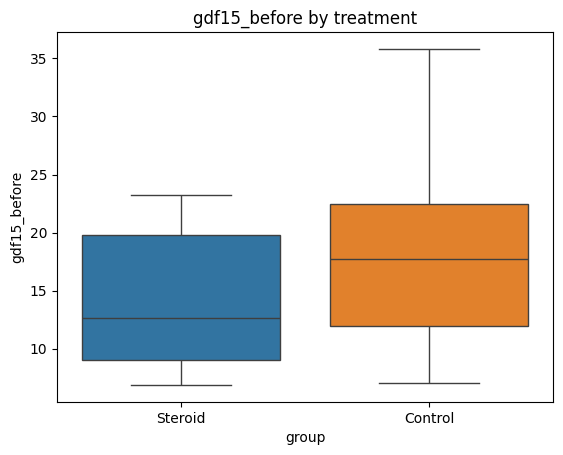

In [8]:
# GDF15 Before
dist_boxplot(data_update, 'gdf15_before')

In [9]:
perform_statistical_tests(data_update, 'group', 'gdf15_before', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.14584112788487083
Shapiro-Wilk test for Control (n=11): p-value = 0.563749602961911
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=11 vs. n=11): t-statistic = -1.2540068462574645, p-value = 0.22429925452130164
Welch's t-test result (n=11 vs. n=11): t-statistic = -1.2540068462574645, p-value = 0.2260070517631878


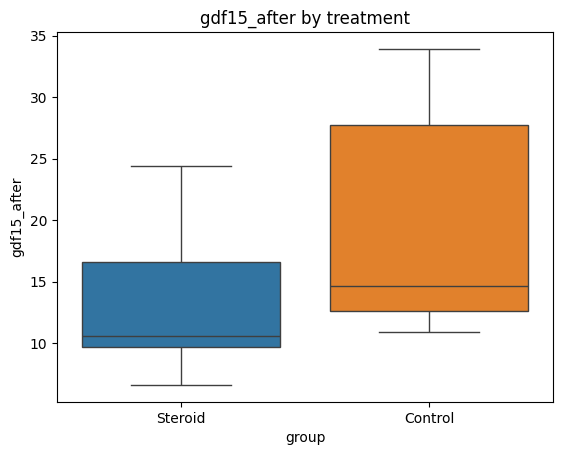

In [10]:
# GDF15 After
dist_boxplot(data_update, 'gdf15_after')

In [11]:
perform_statistical_tests(data_update, 'group', 'gdf15_after', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.19874159077805015
Shapiro-Wilk test for Control (n=11): p-value = 0.02189256856196692
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=11 vs. n=11): U-statistic = 29.0, p-value = 0.04178899680298453


In [12]:
# Function to test for Statistical Significance in Difference between Sample Means
def perform_t_test(data, group_column, value_column, group1, group2):
    """
    Perform statistical tests (normality tests and t-tests or Mann-Whitney U tests) between two groups.

    Parameters:
    - data: DataFrame containing the data.
    - group_column: Column name indicating the group (e.g., 'Race').
    - value_column: The column containing the values to test (e.g., 'IGFBP7').
    - group1: The first group to compare (e.g., 'black').
    - group2: The second group to compare (e.g., 'white').
    """
    # Filter and remove NaN values for both groups
    group1_data = data[data[group_column] == group1][value_column].dropna()
    group2_data = data[data[group_column] == group2][value_column].dropna()

    # Check the sample size
    if len(group1_data) < 3 or len(group2_data) < 3:
        print(f"Not enough data for statistical testing. {group1}: {len(group1_data)}, {group2}: {len(group2_data)}")
        return   
        
    # Perform Independent t-test (assuming equal variances)
    t_stat, p_value = stats.ttest_ind(group1_data, group2_data)
    print(f"Independent t-test result (n={len(group1_data)} vs. n={len(group2_data)}): t-statistic = {t_stat}, p-value = {p_value}")
   

In [13]:
perform_t_test(data_update, 'group', 'gdf15_after', 'Steroid', 'Control')

Independent t-test result (n=11 vs. n=11): t-statistic = -1.989625554297901, p-value = 0.06048177525960365


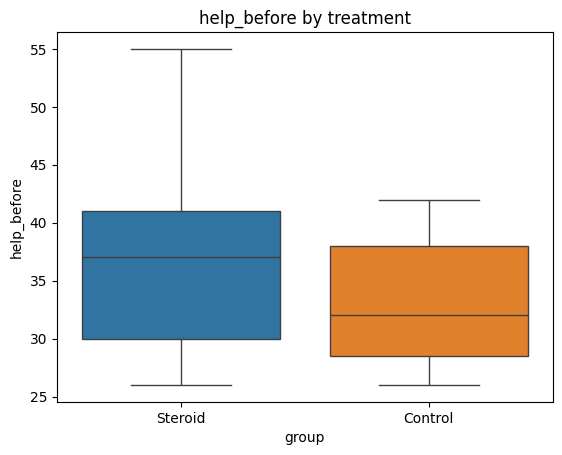

In [14]:
# HELP Before
dist_boxplot(data_update, 'help_before')

In [15]:
perform_statistical_tests(data_update, 'group', 'help_before', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.4697594148248439
Shapiro-Wilk test for Control (n=11): p-value = 0.09942919916614272
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=11 vs. n=11): t-statistic = 1.1953810004112362, p-value = 0.24592031851207333
Welch's t-test result (n=11 vs. n=11): t-statistic = 1.1953810004112362, p-value = 0.24727665370254676


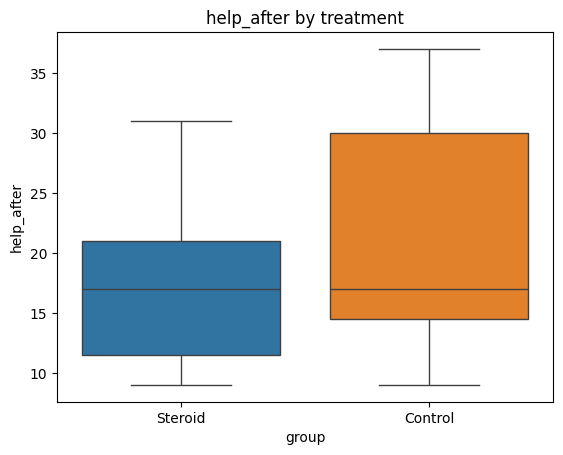

In [16]:
# HELP After
dist_boxplot(data_update, 'help_after') 

In [17]:
perform_statistical_tests(data_update, 'group', 'help_after', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.2742526570383335
Shapiro-Wilk test for Control (n=11): p-value = 0.15188862750054813
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=11 vs. n=11): t-statistic = -1.152523909604337, p-value = 0.26269590490412376
Welch's t-test result (n=11 vs. n=11): t-statistic = -1.152523909604337, p-value = 0.2634302272307022


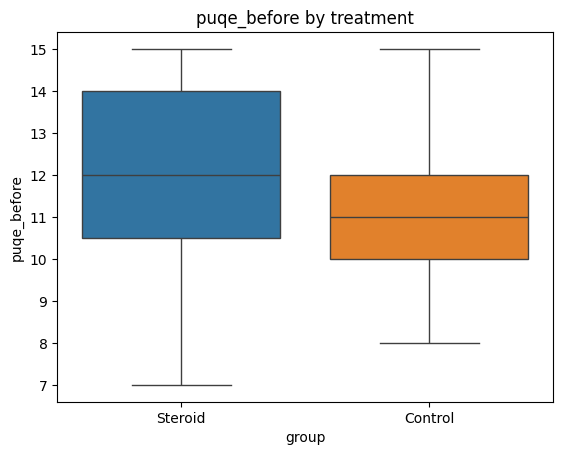

In [18]:
# PUQE Before
dist_boxplot(data_update, 'puqe_before') 

In [19]:
perform_statistical_tests(data_update, 'group', 'puqe_before', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.4370161633950503
Shapiro-Wilk test for Control (n=11): p-value = 0.2960892713267498
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=11 vs. n=11): t-statistic = 0.43453624965687265, p-value = 0.6685512837831329
Welch's t-test result (n=11 vs. n=11): t-statistic = 0.43453624965687265, p-value = 0.6687347035869255


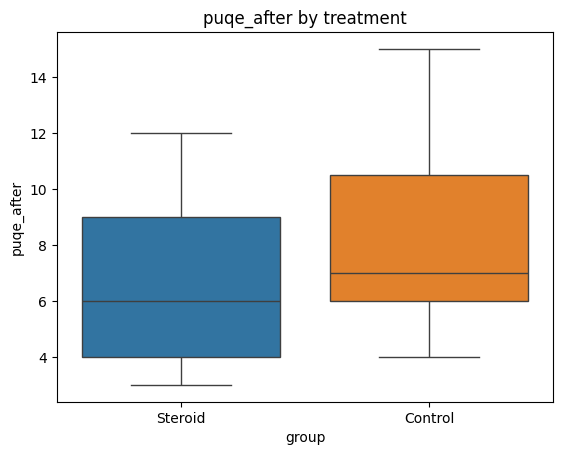

In [20]:
# PUQE After
dist_boxplot(data_update, 'puqe_after') 

In [21]:
perform_statistical_tests(data_update, 'group', 'puqe_after', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.30144320040462214
Shapiro-Wilk test for Control (n=11): p-value = 0.5237682126377838
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=11 vs. n=11): t-statistic = -1.229880092536182, p-value = 0.2330137295841764
Welch's t-test result (n=11 vs. n=11): t-statistic = -1.229880092536182, p-value = 0.2331291750466861


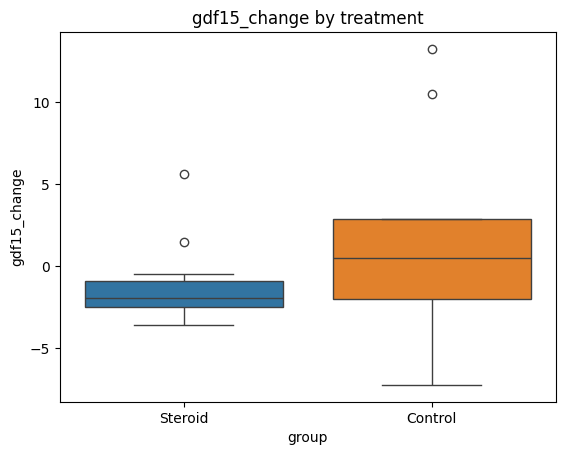

In [22]:
# GDF15 Change
dist_boxplot(data_update, 'gdf15_change') 

In [23]:
perform_statistical_tests(data_update, 'group', 'gdf15_change', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.009186530312759173
Shapiro-Wilk test for Control (n=11): p-value = 0.40175209331412476
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=11 vs. n=11): U-statistic = 42.0, p-value = 0.23721752775378102


In [24]:
perform_t_test(data_update, 'group', 'gdf15_change', 'Steroid', 'Control')

Independent t-test result (n=11 vs. n=11): t-statistic = -1.2696682935954942, p-value = 0.21877798550867633


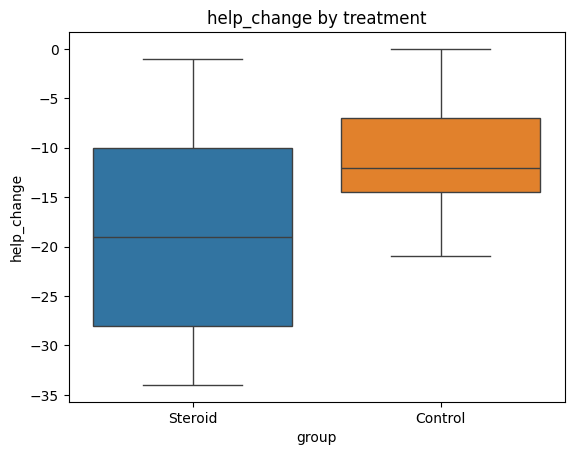

In [25]:
# HELP Change
dist_boxplot(data_update, 'help_change') 

In [26]:
perform_statistical_tests(data_update, 'group', 'help_change', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.581434555322151
Shapiro-Wilk test for Control (n=11): p-value = 0.8091791193681913
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=11 vs. n=11): t-statistic = -2.0502679825817562, p-value = 0.05367650813596159
Welch's t-test result (n=11 vs. n=11): t-statistic = -2.0502679825817562, p-value = 0.05726909246675122


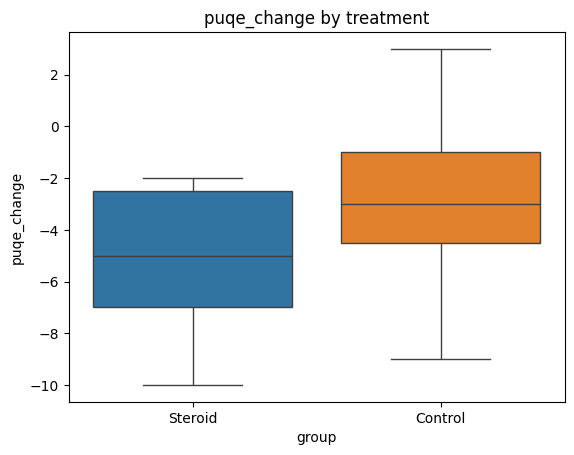

In [27]:
# PUQE Change
dist_boxplot(data_update, 'puqe_change') 

In [28]:
perform_statistical_tests(data_update, 'group', 'puqe_change', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.3382294528445681
Shapiro-Wilk test for Control (n=11): p-value = 0.7626719947485254
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=11 vs. n=11): t-statistic = -1.5955303305205966, p-value = 0.12627470013414477
Welch's t-test result (n=11 vs. n=11): t-statistic = -1.5955303305205966, p-value = 0.12694034104474855


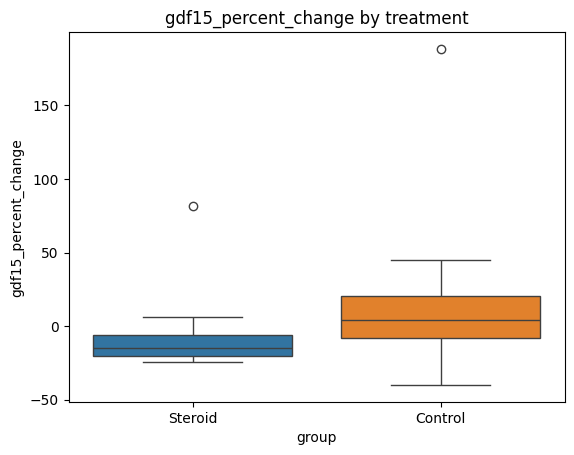

In [29]:
# GDF15 Percent Change
dist_boxplot(data_update, 'gdf15_percent_change') 

In [30]:
perform_statistical_tests(data_update, 'group', 'gdf15_percent_change', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 4.945807184749589e-05
Shapiro-Wilk test for Control (n=11): p-value = 0.0006811146463075098
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=11 vs. n=11): U-statistic = 39.0, p-value = 0.16790547565263503


## Load In New Data Tables

In [31]:
# Read in multiple sheets
sheets = pd.read_excel("steroid_study_tables.xlsx", sheet_name=['GA', 'race_prepreg-weight'])

In [32]:
# Create df from GA sheet
ga_table = sheets['GA']

# Create df from race_prepreg-weight sheet
race_weight_table = sheets['race_prepreg-weight']

## Clean Data / Merge tables

In [33]:
# Clean ID column in race_weight_table
race_weight_table['ID'] = race_weight_table['ID'].str.split(" ").str[0]

# Drop duplicates in race_weight_table
race_weight_table_no_dupilcates = race_weight_table.drop_duplicates(subset=['ID'])

In [34]:
# Merge GA table with clinical data table with race_weight table
merged_data_update_ga = ga_table.merge(data_update, how='inner', on='ID')
merged_data = race_weight_table_no_dupilcates.merge(merged_data_update_ga, how='right', on='ID')

# Standardize column names
merged_data = merged_data.rename(columns={'Race': 'race', 'Prepregnancy_Weight': 'prepregnancy_weight', 'group': 'treatment_group', 
                            'GA prior visit to steroids': 'ga_before', 'GA steroid visit': 'ga_after'})
merged_data = merged_data.drop(columns=['steroid_group'])

## Linear Regression

**Question** 
- Is there an association between steroid treatment (y/n) and GDF15 given gestational age, race, and prepregnancy weight?

**Method** 
- Use linear regression model to "control for" race, prepregnancy weight, and gestational age while estimating the effect of GDF15.
- Check model assumptions

## Define Model Function

In [35]:
def run_regression_with_diagnostics(df, ga, outcome_var):
    """
    Fits linear regression for GDF15 ~ treatment_group + ga_before + prepregnancy_weight + race,
    prints summary, runs assumption tests, and shows diagnostic plots.
    """
    # Ensure categorical vars are treated as categorical
    merged_data['treatment_group'] = merged_data['treatment_group'].astype('category')
    merged_data['race'] = merged_data['race'].astype('category')

    # Build formula
    formula = f"{outcome_var} ~ treatment_group + {ga} + prepregnancy_weight + race"
    model = smf.ols(formula=formula, data=merged_data).fit()

    print("\n===== Regression Summary =====")
    print(model.summary())

    # Residuals and fitted values
    residuals = model.resid
    fitted = model.fittedvalues

    # ===== Assumption Tests =====
    print("\n===== Assumption Tests =====")

    # Shapiro-Wilk Test for Normality
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    print(f"Shapiro-Wilk test p-value (normality): {shapiro_p:.4f} "
          f"{'(normal)' if shapiro_p > 0.05 else '(not normal)'}")

    # Breusch-Pagan Test for Homoscedasticity
    bp_test = het_breuschpagan(residuals, model.model.exog)
    bp_labels = ['LM stat', 'LM p-value', 'F-stat', 'F p-value']
    bp_results = dict(zip(bp_labels, bp_test))
    print(f"Breusch-Pagan test p-value (homoscedasticity): {bp_results['LM p-value']:.4f} "
          f"{'(equal variances)' if bp_results['LM p-value'] > 0.05 else '(unequal variances)'}")

    # ===== Diagnostic Plots =====
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # 1. Residuals vs Fitted
    sns.scatterplot(x=fitted, y=residuals, ax=axes[0, 0])
    axes[0, 0].axhline(0, color='red', linestyle='--')
    axes[0, 0].set_title('Residuals vs Fitted')
    axes[0, 0].set_xlabel('Fitted values')
    axes[0, 0].set_ylabel('Residuals')

    # 2. Q-Q plot
    sm.qqplot(residuals, line='45', ax=axes[0, 1])
    axes[0, 1].set_title('Normal Q-Q')

    # 3. Scale-Location (Spread vs Fitted)
    sns.scatterplot(x=fitted, y=np.sqrt(np.abs(residuals)), ax=axes[1, 0])
    axes[1, 0].axhline(0, color='red', linestyle='--')
    axes[1, 0].set_title('Scale-Location')
    axes[1, 0].set_xlabel('Fitted values')
    axes[1, 0].set_ylabel('√|Residuals|')

    # 4. Residuals vs Leverage
    sm.graphics.influence_plot(model, ax=axes[1, 1], criterion="cooks")

    plt.tight_layout()
    plt.show()

    return model

## Run Model 1
- with ga_before
- dependent variable: gdf15_after


===== Regression Summary =====
                            OLS Regression Results                            
Dep. Variable:            gdf15_after   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     2.665
Date:                Fri, 08 Aug 2025   Prob (F-statistic):             0.0616
Time:                        13:47:54   Log-Likelihood:                -70.460
No. Observations:                  22   AIC:                             152.9
Df Residuals:                      16   BIC:                             159.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

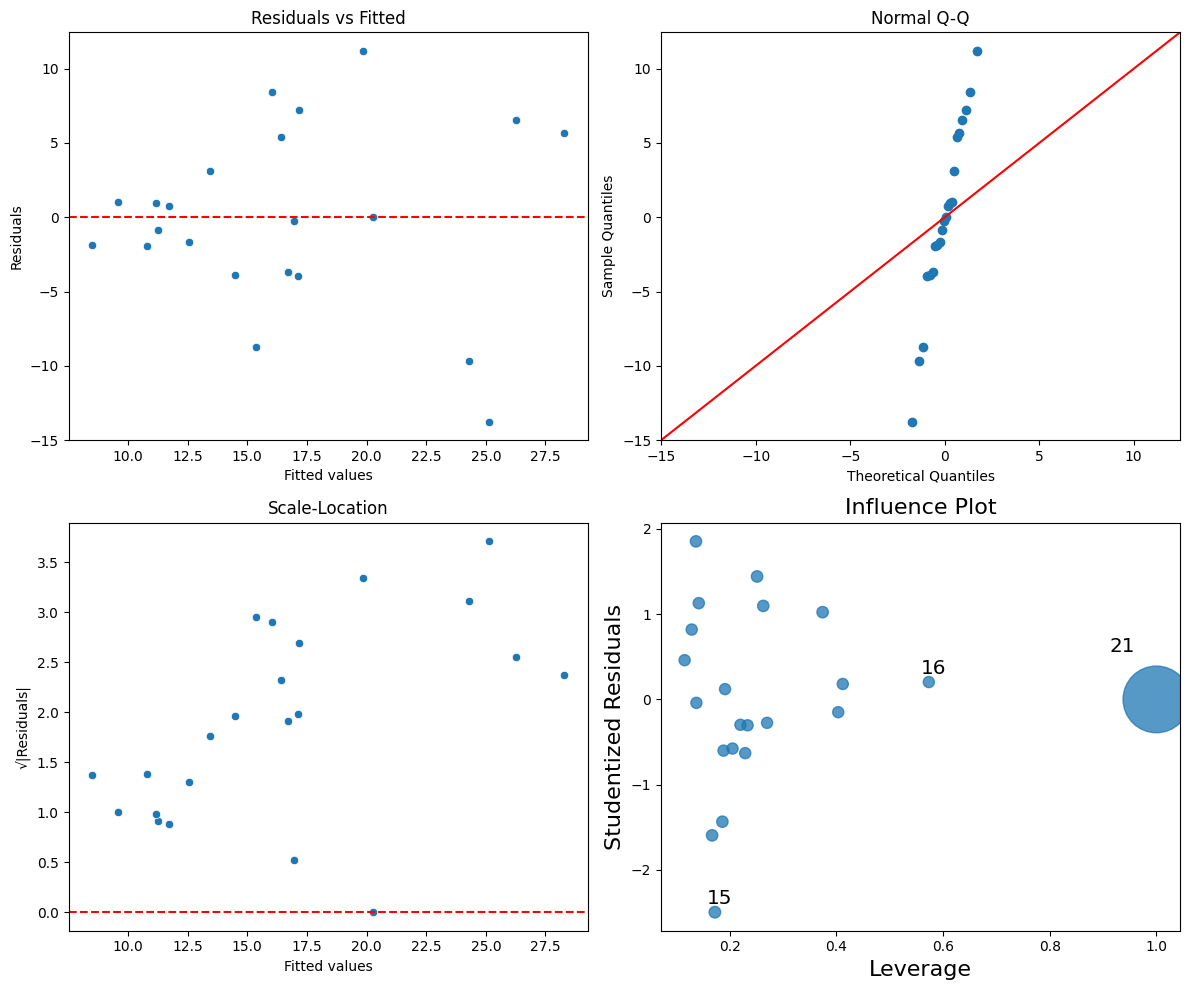

In [36]:
model_1 = run_regression_with_diagnostics(merged_data, ga='ga_before', outcome_var='gdf15_after')

### Visualize Relationships 

#### Plot Adjusted Means

In [43]:
def plot_adjusted_means(model, dependent_var, ga_var, data, model_name="Adjusted Means Plot"):
    """
    Plot adjusted means of dependent_var by treatment_group from the given model.
    Controls for ga_var, prepregnancy_weight, and race (reference category).

    Parameters:
    - model: fitted statsmodels OLS regression result object
    - dependent_var: str, name of dependent variable (for y-axis label)
    - ga_var: str, gestational age variable used in model ('ga_before' or 'ga_after')
    - data: pd.DataFrame used to fit the model
    - model_name: str, optional title for the plot

    Returns:
    - pd.DataFrame with treatment_group, predicted means, and confidence intervals
    """
    # Calculate means of continuous covariates
    mean_ga = data[ga_var].mean()
    mean_weight = data['prepregnancy_weight'].mean()

    # Reference race category (usually first in categories)
    ref_race = data['race'].cat.categories[0]

    # Prepare dataframe for prediction: all covariates fixed except treatment_group
    predict_df = pd.DataFrame({
        'treatment_group': data['treatment_group'].cat.categories,
        ga_var: mean_ga,
        'prepregnancy_weight': mean_weight,
        'race': ref_race
    })

    # Predict adjusted means
    predict_df['predicted'] = model.predict(predict_df)

    # Get confidence intervals
    pred_summary = model.get_prediction(predict_df)
    predict_df[['ci_lower', 'ci_upper']] = pred_summary.conf_int()

    # Plot
    plt.figure(figsize=(7,5))
    plt.errorbar(
        x=predict_df['treatment_group'],
        y=predict_df['predicted'],
        yerr=[predict_df['predicted'] - predict_df['ci_lower'], predict_df['ci_upper'] - predict_df['predicted']],
        fmt='o',
        capsize=5,
        color='blue'
    )
    plt.title(model_name)
    plt.xlabel('Treatment Group')
    plt.ylabel(f'Predicted {dependent_var}')
    plt.grid(True)
    plt.show()

    return predict_df[['treatment_group', 'predicted', 'ci_lower', 'ci_upper']]

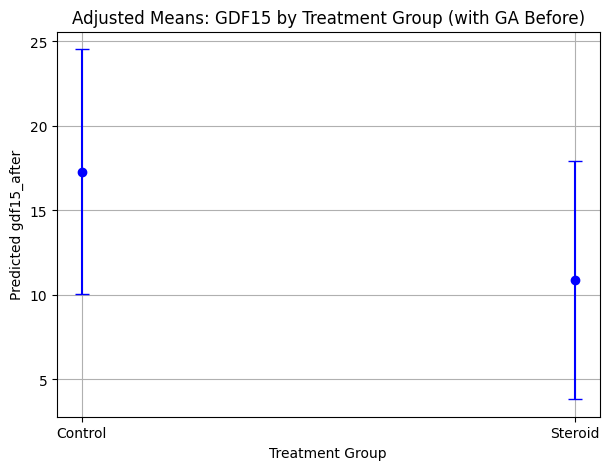

,treatment_group,predicted,ci_lower,ci_upper
0,Control,17.291935,10.044066,24.539804
1,Steroid,10.879427,3.830154,17.928700


In [44]:
plot_adjusted_means(model_1, 'gdf15_after', 'ga_before', merged_data, "Adjusted Means: GDF15 by Treatment Group (with GA Before)")

#### Adjusted means graph interpretation
- The steroid group’s predicted GDF15 is slightly lower than the control group’s, consistent with the regression coefficient (about 6 units lower).
- The confidence intervals overlap a bit, reflecting the borderline statistical significance (p ~0.057).
- This suggests a trend toward steroids lowering GDF15 levels after treatment, but with the current sample size, we can’t be fully confident that the difference isn’t due to chance.
    - With larger samples, the confidence intervals may narrow, clarifying the steroid effect further.

#### Plot Prepregnancy weight vs GDF15 Levels After Steroid Treatment

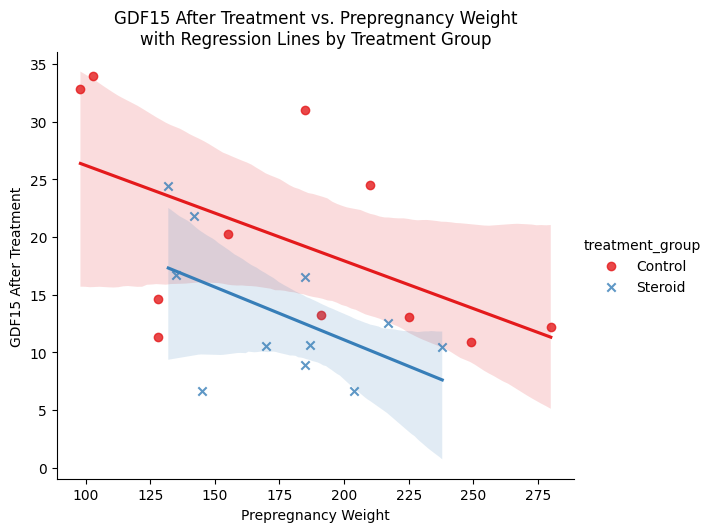

In [45]:
# Prepregnancy weight vs GDDF15 levels after steroids
sns.lmplot(
    x='prepregnancy_weight', 
    y='gdf15_after', 
    data=merged_data, 
    hue='treatment_group',      # Separate lines/colors for steroid vs control
    markers=['o', 'x'],          # Different markers for groups
    palette='Set1',
    aspect=1.2
)

plt.title('GDF15 After Treatment vs. Prepregnancy Weight\nwith Regression Lines by Treatment Group')
plt.xlabel('Prepregnancy Weight')
plt.ylabel('GDF15 After Treatment')
plt.show()

### Model 1 Interpretation
- Model explains ~31-45% of variance in post-treatment GDF15 (moderate fit).

- The steroid treatment group tends to have lower GDF15 after treatment by ~6.4 units compared to control, adjusting for gestational age, race, and weight — this effect is borderline statistically significant (p=0.057).

- Race (Black vs White) and gestational age before treatment do not significantly predict GDF15 after treatment in this small sample.

- **Prepregnancy weight shows a significant negative association** with GDF15: higher weight corresponds to slightly lower GDF15.

- Model assumptions hold up well based on normality and homoscedasticity tests.

## Run Model 2
- with ga_after
- dependent variable: gdf15_after


===== Regression Summary =====
                            OLS Regression Results                            
Dep. Variable:            gdf15_after   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     2.727
Date:                Fri, 08 Aug 2025   Prob (F-statistic):             0.0575
Time:                        14:00:27   Log-Likelihood:                -70.345
No. Observations:                  22   AIC:                             152.7
Df Residuals:                      16   BIC:                             159.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

/Users/hannahthompson/Documents/hg_project_2/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


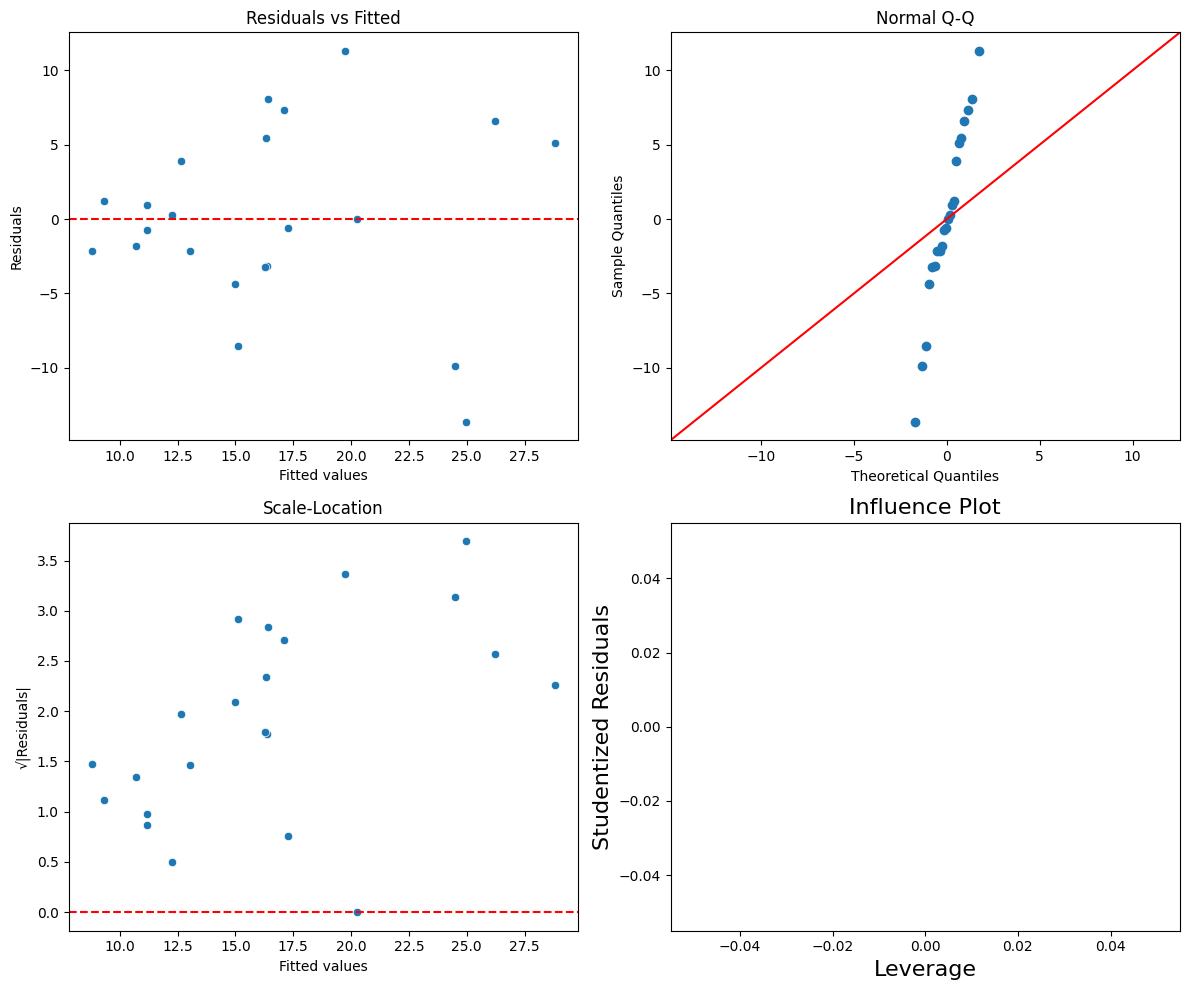

In [48]:
model_2 = run_regression_with_diagnostics(merged_data, ga='ga_after', outcome_var='gdf15_after')

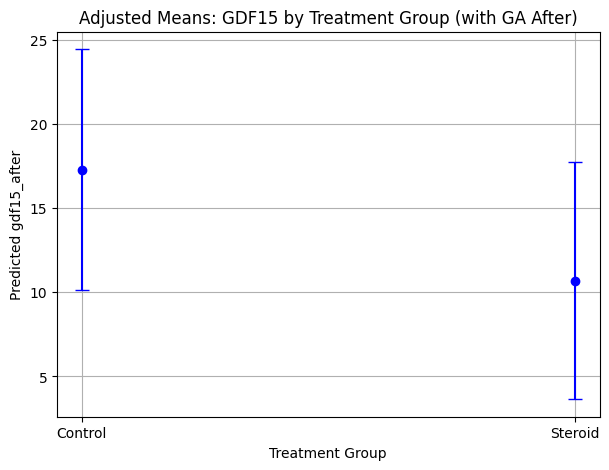

,treatment_group,predicted,ci_lower,ci_upper
0,Control,17.281369,10.111479,24.451260
1,Steroid,10.683222,3.646392,17.720052


In [47]:
plot_adjusted_means(model_2, 'gdf15_after', 'ga_after', merged_data, "Adjusted Means: GDF15 by Treatment Group (with GA After)")

#### Adjusted means graph interpretation
- The steroid group’s predicted GDF15 is slightly lower than the control group’s, consistent with the regression coefficient (about 6 units lower).
- The confidence intervals overlap a bit, but this model with the GA after treatment produces statistical significance (p ~0.046).
- This suggests a trend toward steroids lowering GDF15 levels after treatment.
    - With larger samples, the confidence intervals may narrow, clarifying the steroid effect further.

### Model 2 Interpretation 

- Slightly better fit than the previous model (0.449 → 0.460), explaining ~46% of variance.

- The overall model is borderline significant, just above the 0.05 threshold with Probablity (F-statistic) ~0.575.

- **The steroid effect is now statistically significant at p<0.05**, indicating steroids are associated with ~6.6 unit lower GDF15 after treatment, adjusting for all covariates.

- Neither race category is significant; their effects are small and uncertain here.

- Gestational age at post-treatment measurement is not a significant predictor.

- **Prepregnancy weight remains a significant negative predictor of GDF15**, consistent with before.

- Model assumptions hold up well based on normality and homoscedasticity tests.

- This updated model with ga_after looks like a better fit and provides stronger evidence for the steroid effect on GDF15.

#### Why is Model 2 better?
- ga_after better represents the actual timing of the GDF15 measurement.
- Using ga_before might miss natural changes in GDF15 that happen as pregnancy progresses, confounding effects.

## Overall Insights

After controlling for gestational age and race, we find that steroid treatment is significantly associated with lower GDF15 levels. Race itself does not appear to influence GDF15 significantly in this sample, nor does gestational age at the time of measurement. However, prepregnancy weight also significantly predicts GDF15, with higher weight linked to lower GDF15.